In [1]:
from data_generators import get_iterator, get_dataset
from classifiers import theme_classifier
import torch
import torch.nn as nn
from torchtext.vocab import GloVe 
GLOVE_EMBEDDING = GloVe(name="6B", dim=300)

In [2]:
train_dataset, val_dataset, test_dataset, review_text_FIELD, theme_FIELD = get_dataset(vectors = GLOVE_EMBEDDING)

In [3]:
batch_size = 20
train_iter = get_iterator(train_dataset, batch_size, train=True, shuffle=True, repeat=False)
val_iter = get_iterator(val_dataset, batch_size, train=False, shuffle=True, repeat=False)
test_iter = get_iterator(test_dataset, batch_size, train=False, shuffle=True, repeat=False)

In [4]:
test_list = list(test_iter)

In [5]:
from baseline_model import BaseModel, repackage_hidden

In [6]:
with open('./baseline/best_model_base_model_ppl_67.5461793533482.model', 'rb') as file:
    model = torch.load(file)
    model.eval()

In [7]:
vocab_size = 12304

In [43]:
import numpy as np
from torch.autograd import Variable
from torch.distributions import Categorical

In [256]:
def select_action(policy, state):
    data, labels, hidden = state
    
    #state = torch.from_numpy(data).type(torch.FloatTensor)
    state, hidden = policy(data, labels, hidden)
    state = torch.softmax(state, -1)
    #print('state.shape', state.shape)
    c = Categorical(state)
    action = c.sample()
    #print('action.shape', action.shape)
    
    prob = c.log_prob(action).cuda()
    
    if len(policy.policy_history.shape) != 0:
        policy.policy_history = torch.cat([policy.policy_history.cuda(), prob.unsqueeze(0)])
    else:
        policy.policy_history = prob
        
    return action, prob, hidden

In [257]:
def update_policy(policy, optimizer):
    R = 0
    rewards = []
    
    # Discount future rewards back to the present using gamma
    for r in policy.reward_episode[::-1]:
        R = r + policy.gamma * R
        rewards.insert(0,R)
        
    # Scale rewards
    # print(len(rewards), rewards[0].shape)
    # 4 torch.Size([1, 20])
    
    #rewards = torch.FloatTensor(rewards)
    rewards = torch.cat(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    
    classifier_output = 1    
    rewards = rewards * classifier_output
    
    # Calculate loss
    #print(policy.policy_history.squeeze(1).shape, Variable(rewards).shape)
    loss = (torch.sum(torch.mul(policy.policy_history.squeeze(1), Variable(rewards)).mul(-1), -1))
    loss = loss.sum()
    
    # print('loss.shape', loss.shape)
    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Save and intialize episode history counters
    policy.loss_history.append(loss.item())
    policy.reward_history.append(np.sum(policy.reward_episode))
    policy.policy_history = Variable(torch.Tensor()).cuda()
    policy.reward_episode= []

In [258]:
EOS_token = review_text_FIELD.vocab.stoi['<eos>']
EOS_token

3

In [259]:
def main(episodes, policy, optimizer, gamma, source):
    
    running_reward = 20
    for episode in range(episodes):
        
        labels = source.theme.cuda().long() - 1
        data = source.review_text.cuda().long()
        
        hidden = None
        action = data[0,:].unsqueeze(0)
        for time in range(data.shape[0]): #seq_len!!!
            action, prob, hidden = select_action(policy, state=(action, labels, hidden))
            
            policy.reward_episode.append(prob)
        
        # Used to determine when the environment is solved.
        running_reward = (running_reward * gamma) + (time * 0.01)
        
        update_policy(policy, optimizer)

In [260]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [261]:
for i, batch in enumerate(test_list):
    labels = batch.theme.cuda().long() - 1
    batch = batch.review_text.cuda().long()
    if batch.shape[0] > 3:
        print(i)
        break
ok_test_list = test_list[i:]

25


In [262]:
class ReinforcedModel(nn.Module):

    def __init__(self, base_model, gamma):
        super().__init__()

        self.base_model = base_model.cuda()
        self.gamma = gamma

        self.policy_history = Variable(torch.Tensor()).cuda()
        self.reward_episode = []
        self.reward_history = []
        self.loss_history = []

    def forward(self, data, labels, hidden):    
        x = self.base_model(data, labels, hidden)
        return x

In [263]:
policy = ReinforcedModel(model, 0.99).cuda()

In [264]:
ok_test_list[0].review_text.shape

torch.Size([4, 20])

In [280]:
episodes = 6
main(episodes, policy, optimizer, 0.99, ok_test_list[0])

In [281]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

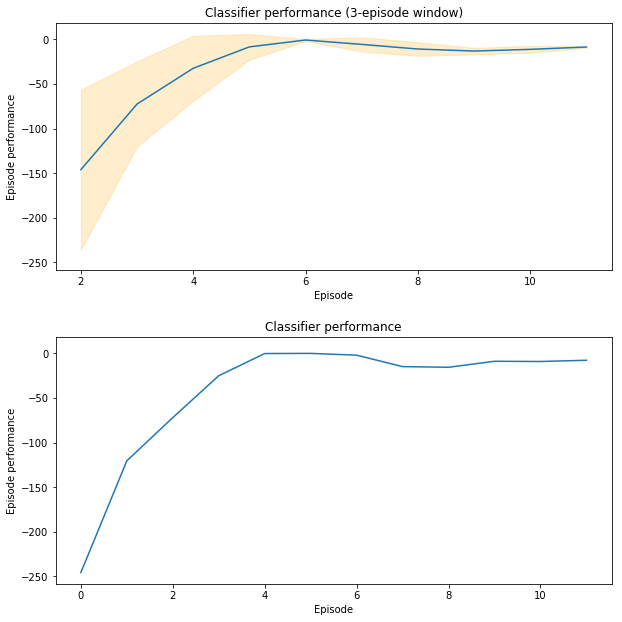

In [293]:
window = 3#int(episodes/20)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9]);

reward_history = [x.sum() for x in policy.reward_history]

rolling_mean = pd.Series(reward_history).rolling(window).mean()
std = pd.Series(reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(reward_history)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title('Classifier performance ({}-episode window)'.format(window))
ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode performance')

ax2.plot(reward_history)
ax2.set_title('Classifier performance')
ax2.set_xlabel('Episode'); ax2.set_ylabel('Episode performance')

fig.tight_layout(pad=2)
plt.show()
#fig.savefig('results.png')

